In [52]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import datasets

sys.path.insert(0, '../')
from config import Config, ModelType, TrainArgs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# available datasets
dataset_list = datasets.list_datasets()

for data in dataset_list:
    if 'ko' in data:
        print(data)

kor_3i4k
kor_hate
kor_ner
kor_nli
kor_nlu
kor_qpair
kor_sae
kor_sarcasm
squad_kor_v1
squad_kor_v2
abwicke/koplo
godzillavskongonlinetv/ergfdg
godzillavskongonlinetv/godzillavskongfullmovie


In [10]:
# 네이버에서 제공하는 영화 후기 관련 데이터셋
dataset = datasets.load_dataset('nsmc')
print(dataset)

Using custom data configuration default
Reusing dataset nsmc (/opt/ml/.cache/huggingface/datasets/nsmc/default/1.1.0/e6d4f29f56bfe0b31765f822595dd73e04b2cdfda732c9d787c1b80e1ff6ecfb)
DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [12]:
train_data = pd.DataFrame(
    dict(
        document=dataset['train']['document'],
        label=dataset['train']['label'])
)

test_data = pd.DataFrame(
    dict(
        document=dataset['test']['document'],
        label=dataset['test']['label'])
)

## 중복 제거

In [16]:
print('Uniqueness for Train')
print(
    'Document:', train_data['document'].nunique(),
    'Label:', train_data['label'].nunique()
    )
print(
    'Document:', test_data['document'].nunique(),
    'Label:', test_data['label'].nunique()
    )

Uniqueness for Train
Document: 146183 Label: 2
Document: 49158 Label: 2


In [18]:
train_data.drop_duplicates(subset=['document'], inplace=True)

test_data.drop_duplicates(subset=['document'], inplace=True)

In [19]:
print('Uniqueness for Train')
print(
    'Document:', train_data['document'].nunique(),
    'Label:', train_data['label'].nunique()
    )
print(
    'Document:', test_data['document'].nunique(),
    'Label:', test_data['label'].nunique()
    )

Uniqueness for Train
Document: 146183 Label: 2
Document: 49158 Label: 2


## Null 제거

In [21]:
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'].replace('', np.nan, inplace=True)

In [22]:
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)

In [26]:
train_data.shape, test_data.shape

((146182, 2), (49157, 2))

In [30]:
length_list = [len(l) for l in train_data['document']]

max_len = max(length_list)
mean_len = sum(length_list) / len(length_list)

print('Max Length:', max_len)
print('Average Length:', mean_len)


Max Length: 146
Average Length: 35.981338331668745


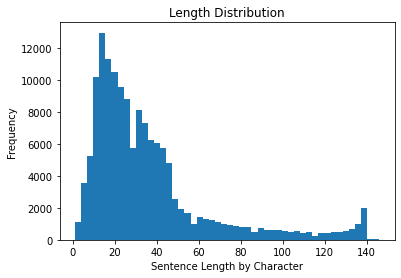

In [32]:
plt.hist(length_list, bins=50)
plt.title('Length Distribution')
plt.xlabel('Sentence Length by Character')
plt.ylabel('Frequency')
plt.show()

## Train with BERT, Hugging Face

In [33]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [36]:
tokenizer = AutoTokenizer.from_pretrained(ModelType.BertMultiLingual)

In [37]:
tokenized_train_sentences = tokenizer(
    text=list(train_data['document']),
    return_tensors='pt',
    padding=True,
    truncation=True,
    add_special_tokens=True

)

In [47]:
tokenized_test_sentences = tokenizer(
    text=list(test_data['document']),
    return_tensors='pt',
    padding=True,
    truncation=True,
    add_special_tokens=True

)

In [38]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=142, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [41]:
class SingleSentDataset(Dataset):
    def __init__(self, tokenized_sentences, labels):
        self.tokenized_sentences = tokenized_sentences
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key:torch.as_tensor(val[idx]) for key, val in self.tokenized_sentences.items()}
        item['labels'] = torch.as_tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [48]:
train_labels = train_data['label'].tolist()
test_labels = test_data['label'].tolist()

In [49]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_labels)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_labels)

In [51]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [58]:
args = {
    'output_dir': '../saved_models',
    'overwrite_output_dir': True,
    'num_train_epochs': 1,
    'per_device_train_batch_size': 32,
    'per_device_train_batch_size': 64,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'seed': 42,
    'logging_dir': '../logs',
    'logging_steps': 100,
    'save_steps': 1000,
    'save_total_limit': 2
 }

In [59]:
training_args = TrainingArguments(**args)

In [65]:
model = BertForSequenceClassification.from_pretrained(ModelType.BertMultiLingual, num_labels=42).to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [63]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

In [64]:
trainer.train()

Step,Training Loss


KeyboardInterrupt: 

In [66]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [67]:
def compute_metrics(pred, labels):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return dict(
        accuracy=acc,
        f1=f1,
        precision=precision,
        recall=recall
        )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate(eval_dataset=test_dataset)

## Trainer를 사용하지 않을 경우

In [ ]:
# native training using torch

model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

In [ ]:
# predict함수
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,\\
            max_length=128
    )
    tokenized_sent.to(device)
    
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

Prediction 코드를 짜지 않아도 pipeline을 통해 구할 수 있다

In [ ]:
from transformers import pipeline

nlp_sentence_classif = pipeline('sentiment-analysis',model=model, tokenizer=tokenizer, device=0)

print(nlp_sentence_classif('영화 개재밌어 ㅋㅋㅋㅋㅋ'))
print(nlp_sentence_classif('진짜 재미없네요 ㅋㅋ'))
print(nlp_sentence_classif('너 때문에 진짜 짜증나'))
print(nlp_sentence_classif('정말 재밌고 좋았어요.'))